In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import tensorflow_probability as tfp

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import shuffle

In [2]:
#load the mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
################################################################################
#reshape the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
#convert the data to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#normalize the data
x_train /= 255
x_test /= 255
#convert the labels to categorical vectors
y_train = tf.keras.utils.to_categorical(y_train, 20)
y_test = tf.keras.utils.to_categorical(y_test, 20)
################################################################################
#import the fashion mnist dataset and preprocess the images
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()
#add 10 to every element in y_train_fashion and y_test_fashion, we don't want the neural network to tell something like three is a boot
y_train_fashion = y_train_fashion + 10
y_test_fashion = y_test_fashion + 10
x_train_fashion = x_train_fashion.reshape(x_train_fashion.shape[0], 28, 28, 1)
x_test_fashion = x_test_fashion.reshape(x_test_fashion.shape[0], 28, 28, 1)
x_test_fashion = x_test_fashion.astype('float32')
x_train_fashion = x_train_fashion.astype('float32')
x_train_fashion /=255
x_test_fashion /= 255
#convert the labels to categorical vectors
y_train_fashion = tf.keras.utils.to_categorical(y_train_fashion, 20)
y_test_fashion = tf.keras.utils.to_categorical(y_test_fashion, 20)

In [3]:
#define the number of epochs
n_epochs = 15
#define the batch size
batch_size = 256
#calculate the number of batches per epoch for the datasets and 10 epochs : 
batch_par_epoch = int(x_train.shape[0] / batch_size)
#experience replay frequency:
exp_replay_freq = 0.45
is_Conv2D = 1

In [4]:
def is_Conv2D_layer(filters,kernel_size,strides,is_Conv2D = is_Conv2D):
  return Conv2D(filters,kernel_size=kernel_size, strides=strides,activation=leaky_relu, padding='same') if is_Conv2D == 1 else Dense(filters,activation=leaky_relu)

class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

# Section 1: Demonstration of the Catastrophic Interference Problem
See McCloskey and Cohen (1989) for the seminal paper.

In [5]:
#create a network named NET 1 wich learns to associate the input image with the corresponding class label
leaky_relu = tf.keras.layers.LeakyReLU(0.2)
def net1():
    model = tf.keras.models.Sequential()
    if is_Conv2D == 0:
      model.add(Flatten())
    model.add(is_Conv2D_layer(128,kernel_size=5,strides=2))
    if is_Conv2D ==1:
      #model.add(tf.keras.layers.SpatialDropout2D(0.1))
      model.add(MaxPooling2D(2))
    model.add(is_Conv2D_layer(256,kernel_size=3, strides=1))
    model.add(is_Conv2D_layer(256,3,strides=1))
    model.add(is_Conv2D_layer(256,3,strides=1))
    if is_Conv2D ==1:
      model.add(MaxPooling2D(2))
    model.add(is_Conv2D_layer(512,3,strides=1))
    model.add(is_Conv2D_layer(512,3,strides=1))
    model.add(is_Conv2D_layer(512,3,strides=1))
    if is_Conv2D ==1:
      model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(1024, activation=leaky_relu))
    model.add(Dense(20, activation='softmax'))
    return model

#create a backpropagating convolutional neural network
net1=net1()
#compile the network
net1.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/15
  5/235 [..............................] - ETA: 7s - loss: 2.9937 - accuracy: 0.1023

235/235 [==============================] - 13s 38ms/step - loss: 2.7730 - accuracy: 0.1367 - val_loss: 2.3108 - val_accuracy: 0.1359
Epoch 2/15
235/235 [==============================] - 7s 30ms/step - loss: 2.2522 - accuracy: 0.1689 - val_loss: 2.2259 - val_accuracy: 0.1021
Epoch 3/15
235/235 [==============================] - 7s 30ms/step - loss: 1.4907 - accuracy: 0.5078 - val_loss: 0.9479 - val_accuracy: 0.6739
Epoch 4/15
235/235 [==============================] - 7s 31ms/step - loss: 0.6856 - accuracy: 0.7756 - val_loss: 0.5161 - val_accuracy: 0.8321
Epoch 5/15
235/235 [==============================] - 7s 31ms/step - loss: 0.4448 - accuracy: 0.8593 - val_loss: 0.3910 - val_accuracy: 0.8715
Epoch 6/15
235/235 [==============================] - 7s 31ms/step - loss: 0.3152 - accuracy: 0.9004 - val_loss: 0.2850 - val_accuracy: 0.9098
Epoch 7/15
235/235 [==============================] - 7s 30ms/step - loss: 0.2476 - accuracy: 0.9223 - val_loss: 0.2365 - val_accuracy: 0.9244
Epoch 8/1

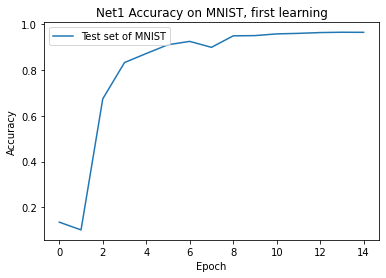

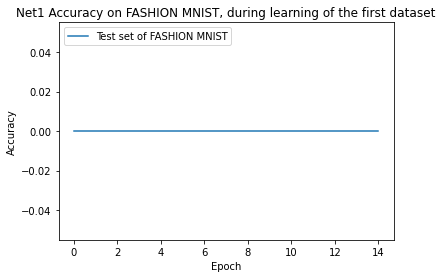

In [6]:
#define a special callback in order to test performance on each dataset at the end of each training epoch
fashion_callback = AdditionalValidationSets([(x_test_fashion, y_test_fashion, 'fashion')],batch_size=batch_size,verbose=0)
#train net1 on mnist dataset, bulk learning
net1.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(x_test,y_test), callbacks=fashion_callback, shuffle = True)
#extract MNIST accuracy to a list
val_accuracy_mnist = fashion_callback.history['val_accuracy']
val_accuracy_fashion = fashion_callback.history['fashion_accuracy']

#plot accuracy
plt.plot(val_accuracy_mnist)
plt.title('Net1 Accuracy on MNIST, first learning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test set of MNIST'], loc='upper left')
plt.show()

#plot accuracy on fashion dataset
plt.plot(val_accuracy_fashion)
plt.title('Net1 Accuracy on FASHION MNIST, during learning of the first dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test set of FASHION MNIST'], loc='upper left')
plt.show()

Epoch 1/15
  5/235 [..............................] - ETA: 6s - loss: 4.9623 - accuracy: 0.1000

235/235 [==============================] - 7s 32ms/step - loss: 1.0819 - accuracy: 0.6337 - val_loss: 0.7509 - val_accuracy: 0.7018
Epoch 2/15
235/235 [==============================] - 7s 31ms/step - loss: 0.6720 - accuracy: 0.7504 - val_loss: 0.6624 - val_accuracy: 0.7636
Epoch 3/15
235/235 [==============================] - 7s 32ms/step - loss: 0.5951 - accuracy: 0.7792 - val_loss: 0.6121 - val_accuracy: 0.7733
Epoch 4/15
235/235 [==============================] - 7s 31ms/step - loss: 0.5460 - accuracy: 0.7985 - val_loss: 0.6225 - val_accuracy: 0.7620
Epoch 5/15
235/235 [==============================] - 8s 33ms/step - loss: 0.5084 - accuracy: 0.8116 - val_loss: 0.5044 - val_accuracy: 0.8162
Epoch 6/15
235/235 [==============================] - 7s 30ms/step - loss: 0.4856 - accuracy: 0.8211 - val_loss: 0.5540 - val_accuracy: 0.7912
Epoch 7/15
235/235 [==============================] - 7s 31ms/step - loss: 0.4670 - accuracy: 0.8278 - val_loss: 0.5249 - val_accuracy: 0.8073
Epoch 8/15

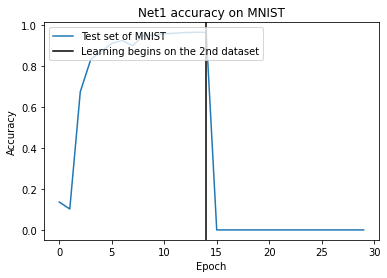

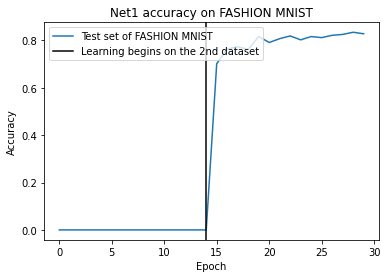

In [7]:
#define a special callback in order to test performance on each dataset at the end of each training epoch
callback_mnist = AdditionalValidationSets([(x_test, y_test, 'mnist')],batch_size=batch_size,verbose=0)

#train net1 on the second dataset
net1.fit(x_train_fashion, y_train_fashion, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(x_test_fashion,y_test_fashion), callbacks=callback_mnist, shuffle = True)

#plots the learning curve on MNIST before and after learning on pseudosamples interleaved with real samples
#extract accuracy to a list
val_accuracy_mnist.extend(callback_mnist.history['mnist_accuracy'])
plt.plot(val_accuracy_mnist)
plt.title('Net1 accuracy on MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axvline(x=int(n_epochs-1), color='k')
plt.legend(['Test set of MNIST', 'Learning begins on the 2nd dataset' ], loc='upper left')
plt.show()

#plot the learning curve on FASHION_MNIST (durinng the interleaving of the pseudosamples representing MNIST only)
val_accuracy_fashion.extend(callback_mnist.history['val_accuracy'])
plt.plot(val_accuracy_fashion)
plt.title('Net1 accuracy on FASHION MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axvline(x=int(n_epochs-1), color='k')
plt.legend(['Test set of FASHION MNIST', 'Learning begins on the 2nd dataset'], loc='upper left')
plt.show()

In [8]:
#evaluate net1 on mnist dataset
print("Loss and performance of net1 on the MNIST dataset:")
net1.evaluate(x_test, y_test, batch_size = batch_size)
#evaluate net1 on fashion_mnist dataset
print("Loss and performance of net1 on the FASHION_MNIST dataset:")
net1.evaluate(x_test_fashion, y_test_fashion, batch_size = batch_size)

Loss and performance of net1 on the MNIST dataset:
40/40 [==============================] - 0s 11ms/step - loss: 11.2577 - accuracy: 0.0000e+00
Loss and performance of net1 on the FASHION_MNIST dataset:
40/40 [==============================] - 0s 10ms/step - loss: 0.4690 - accuracy: 0.8279


[0.4689558148384094, 0.8278999924659729]

# Section 2. Using a feed-forward dual-net architecture on white noise
For an opinion on this type of architecture, see French, R. M., Ans, B., & Rousset, S. (2001)

In [9]:
#create a network named NET 1 wich learns to associate the input image with the corresponding class label
leaky_relu = tf.keras.layers.LeakyReLU(0.2)
def net1():
    model = tf.keras.models.Sequential()
    if is_Conv2D == 0:
      model.add(Flatten())
    model.add(is_Conv2D_layer(128,kernel_size=5,strides=2))
    if is_Conv2D ==1:
      #model.add(tf.keras.layers.SpatialDropout2D(0.1))
      model.add(MaxPooling2D(2))
    model.add(is_Conv2D_layer(256,kernel_size=3, strides=1))
    model.add(is_Conv2D_layer(256,3,strides=1))
    model.add(is_Conv2D_layer(256,3,strides=1))
    if is_Conv2D ==1:
      model.add(MaxPooling2D(2))
    model.add(is_Conv2D_layer(512,3,strides=1))
    model.add(is_Conv2D_layer(512,3,strides=1))
    model.add(is_Conv2D_layer(512,3,strides=1))
    if is_Conv2D ==1:
      model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(1024, activation=leaky_relu))
    model.add(Dense(20, activation='softmax'))
    return model

def net2():
    model = tf.keras.models.Sequential()
    if is_Conv2D == 0:
      model.add(Flatten())
    model.add(is_Conv2D_layer(128,kernel_size=5,strides=2))
    if is_Conv2D ==1:
      #model.add(tf.keras.layers.SpatialDropout2D(0.1))
      model.add(MaxPooling2D(2))
    model.add(is_Conv2D_layer(256,kernel_size=3,strides=1))
    model.add(is_Conv2D_layer(256,3,strides=1))
    model.add(is_Conv2D_layer(256,3,strides=1))
    if is_Conv2D ==1:
      model.add(MaxPooling2D(2))
    model.add(is_Conv2D_layer(512,3,strides=1))
    model.add(is_Conv2D_layer(512,3,strides=1))
    model.add(is_Conv2D_layer(512,3,strides=1))
    if is_Conv2D ==1:
      model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(1024, activation=leaky_relu))
    model.add(Dense(20, activation='softmax'))
    return model

#create the two models
net1=net1()
net2 = net2()
#compile the networks
net1.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
net2.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/15
  6/235 [..............................] - ETA: 5s - loss: 2.9940 - accuracy: 0.0938

235/235 [==============================] - 8s 31ms/step - loss: 2.8484 - accuracy: 0.1234 - val_loss: 2.5688 - val_accuracy: 0.0974
Epoch 2/15
235/235 [==============================] - 7s 32ms/step - loss: 2.2870 - accuracy: 0.1601 - val_loss: 2.2404 - val_accuracy: 0.0892
Epoch 3/15
235/235 [==============================] - 7s 32ms/step - loss: 1.6301 - accuracy: 0.4558 - val_loss: 0.9300 - val_accuracy: 0.6694
Epoch 4/15
235/235 [==============================] - 8s 32ms/step - loss: 0.7193 - accuracy: 0.7571 - val_loss: 0.5274 - val_accuracy: 0.8307
Epoch 5/15
235/235 [==============================] - 7s 30ms/step - loss: 0.4816 - accuracy: 0.8443 - val_loss: 0.4181 - val_accuracy: 0.8628
Epoch 6/15
235/235 [==============================] - 7s 32ms/step - loss: 0.3497 - accuracy: 0.8872 - val_loss: 0.3250 - val_accuracy: 0.8970
Epoch 7/15
235/235 [==============================] - 8s 33ms/step - loss: 0.2757 - accuracy: 0.9122 - val_loss: 0.2496 - val_accuracy: 0.9204
Epoch 8/15

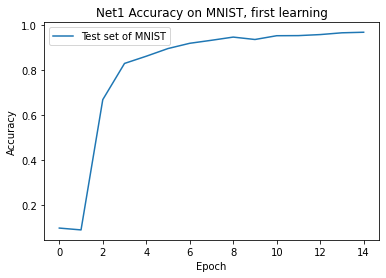

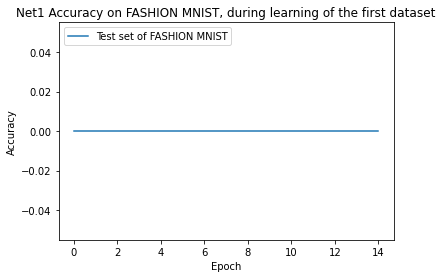

In [10]:
#define a special callback in order to test performance on each dataset at the end of each training epoch
fashion_callback = AdditionalValidationSets([(x_test_fashion, y_test_fashion, 'fashion')],batch_size=batch_size,verbose=0)
#train net1 on mnist dataset, bulk learning
net1.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(x_test,y_test), callbacks=fashion_callback, shuffle = True)
#extract MNIST accuracy to a list
val_accuracy_mnist = fashion_callback.history['val_accuracy']
val_accuracy_fashion = fashion_callback.history['fashion_accuracy']

#plot accuracy
plt.plot(val_accuracy_mnist)
plt.title('Net1 Accuracy on MNIST, first learning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test set of MNIST'], loc='upper left')
plt.show()

#plot accuracy on fashion dataset
plt.plot(val_accuracy_fashion)
plt.title('Net1 Accuracy on FASHION MNIST, during learning of the first dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test set of FASHION MNIST'], loc='upper left')
plt.show()

In [11]:
#create a dataset of completely random white noise
 #define a list of different values for the mean of the noises
mean_list = [np.random.uniform(0, 1) for _ in range(len(x_train))]
 #define a list of different values for the standard deviation of the noises
stddev_list = [np.random.uniform(0, 1) for _ in range(len(x_train))]
 #using each element of mean_list and stddev_list, generate a tensor of random noises by using a truncated normal distribution
noise = tfp.distributions.TruncatedNormal(loc=mean_list,scale=stddev_list, low=0,high=1).sample((28,28,1)) #we use the same shape that is used in the input images
noise = tf.reshape(noise, shape =(len(x_train),28,28,1))

Epoch 1/15
  5/235 [..............................] - ETA: 6s - loss: 2.9595 - accuracy: 0.7891

235/235 [==============================] - 8s 31ms/step - loss: 0.8731 - accuracy: 0.9796 - val_loss: 5.0347 - val_accuracy: 0.1010
Epoch 2/15
235/235 [==============================] - 7s 32ms/step - loss: 0.4944 - accuracy: 0.9838 - val_loss: 5.2708 - val_accuracy: 0.1010
Epoch 3/15
235/235 [==============================] - 7s 32ms/step - loss: 0.4937 - accuracy: 0.9838 - val_loss: 5.2638 - val_accuracy: 0.1010
Epoch 4/15
235/235 [==============================] - 7s 31ms/step - loss: 0.4932 - accuracy: 0.9838 - val_loss: 5.4885 - val_accuracy: 0.1010
Epoch 5/15
235/235 [==============================] - 7s 30ms/step - loss: 0.4931 - accuracy: 0.9838 - val_loss: 5.2710 - val_accuracy: 0.1010
Epoch 6/15
235/235 [==============================] - 7s 31ms/step - loss: 0.4928 - accuracy: 0.9838 - val_loss: 5.4569 - val_accuracy: 0.1010
Epoch 7/15
235/235 [==============================] - 7s 30ms/step - loss: 0.4926 - accuracy: 0.9838 - val_loss: 5.5198 - val_accuracy: 0.1010
Epoch 8/15

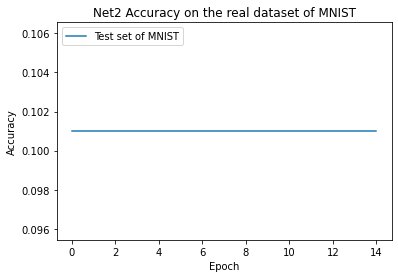

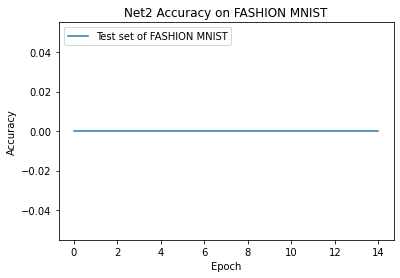

In [12]:
#train net2 on this white noise labeled by net1
#labeling the noise
pseudolabels = net1.predict(noise)
fashion_callback_net2 = AdditionalValidationSets([(x_test_fashion, y_test_fashion, 'fashion')],batch_size=batch_size,verbose=0)
net2.fit(noise, pseudolabels, batch_size = batch_size, epochs = n_epochs,verbose=1, validation_data = (x_test,y_test), callbacks = fashion_callback_net2, shuffle = True)
print("According to the validation accuracy, NET2 has the chance level on its predictions about the MNIST dataset.")
#extract accuracies on real datasets to see the generalization properties of the random noise
val_accuracy_mnist_net2 = fashion_callback_net2.history['val_accuracy']
val_accuracy_fashion_net2 = fashion_callback_net2.history['fashion_accuracy']

#plot accuracy
print("In fact, according to this graph, NET2 isn't really learning anything at all...")
plt.plot(val_accuracy_mnist_net2)
plt.title('Net2 Accuracy on the real dataset of MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test set of MNIST'], loc='upper left')
plt.show()

#plot accuracy on fashion dataset
plt.plot(val_accuracy_fashion_net2)
plt.title('Net2 Accuracy on FASHION MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test set of FASHION MNIST'], loc='upper left')
plt.show()

In [13]:
#Create a new dataset by concatenating the random white noise with the real data coming form FASHION_MNIST
len_pseudo_samples = int(len(x_train_fashion)*exp_replay_freq)
mean_list = [np.random.uniform(0, 1) for _ in range(len_pseudo_samples)]
#define a list of different values for the standard deviation of the noises
stddev_list = [np.random.uniform(0, 1) for _ in range(len_pseudo_samples)]
#using each element of mean_list and stddev_list, generate a tensor of random noises
#with the same shape as the input images and by using a truncated normal distribution
noise = tfp.distributions.TruncatedNormal(loc=mean_list,scale=stddev_list, low=0,high=1).sample((28,28,1))
noise = tf.reshape(noise, shape =(len_pseudo_samples,28,28,1))
#using net2, predict the class of each element in noise
y_noise = net2.predict(noise, batch_size = batch_size)
#generate a new dataset
x_train_fashion_noise = tf.concat([x_train_fashion, noise], axis=0)
y_train_fashion_noise = tf.concat([y_train_fashion, y_noise], axis=0)

Epoch 1/15
  5/340 [..............................] - ETA: 9s - loss: 4.6740 - accuracy: 0.1891

340/340 [==============================] - 11s 31ms/step - loss: 0.8984 - accuracy: 0.7566 - val_loss: 0.7281 - val_accuracy: 0.7215
Epoch 2/15
340/340 [==============================] - 10s 29ms/step - loss: 0.5922 - accuracy: 0.8387 - val_loss: 0.6166 - val_accuracy: 0.7722
Epoch 3/15
340/340 [==============================] - 10s 30ms/step - loss: 0.5444 - accuracy: 0.8557 - val_loss: 0.5557 - val_accuracy: 0.7973
Epoch 4/15
340/340 [==============================] - 10s 30ms/step - loss: 0.5111 - accuracy: 0.8684 - val_loss: 0.5384 - val_accuracy: 0.8040
Epoch 5/15
340/340 [==============================] - 10s 30ms/step - loss: 0.4897 - accuracy: 0.8757 - val_loss: 0.4911 - val_accuracy: 0.8236
Epoch 6/15
340/340 [==============================] - 10s 30ms/step - loss: 0.4721 - accuracy: 0.8824 - val_loss: 0.4936 - val_accuracy: 0.8212
Epoch 7/15
340/340 [==============================] - 10s 30ms/step - loss: 0.4605 - accuracy: 0.8863 - val_loss: 0.4515 - val_accuracy: 0.8358
Epo

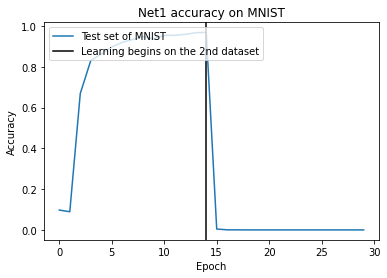

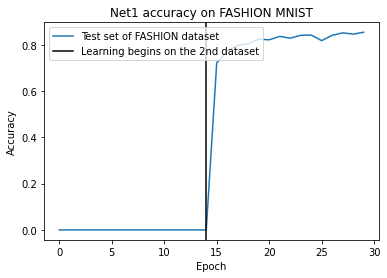

In [14]:
#define a special callback in order to test performance on each dataset at the end of each training epoch
callback_mnist = AdditionalValidationSets([(x_test, y_test, 'mnist')],batch_size=batch_size,verbose=0)

#train net1 on the new dataset
net1.fit(x_train_fashion_noise, y_train_fashion_noise, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(x_test_fashion,y_test_fashion), callbacks=callback_mnist, shuffle = True)

#plots the learning curve on MNIST before and after learning on pseudosamples interleaved with real samples
#extract accuracy to a list
val_accuracy_mnist.extend(callback_mnist.history['mnist_accuracy'])
plt.plot(val_accuracy_mnist)
plt.title('Net1 accuracy on MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axvline(x=int(n_epochs-1), color='k')
plt.legend(['Test set of MNIST', 'Learning begins on the 2nd dataset' ], loc='upper left')
plt.show()

#plot the learning curve on FASHION_MNIST (durinng the interleaving of the pseudosamples representing MNIST only)
val_accuracy_fashion.extend(callback_mnist.history['val_accuracy'])
plt.plot(val_accuracy_fashion)
plt.title('Net1 accuracy on FASHION MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axvline(x=int(n_epochs-1), color='k')
plt.legend(['Test set of FASHION dataset', 'Learning begins on the 2nd dataset'], loc='upper left')
plt.show()

# Section 3: Using a Variational Autoencoder to Solve the Catastrophic Forgetting Problem

In [15]:
#create a network named NET 1 wich learns to associate the input image with the corresponding class label
leaky_relu = tf.keras.layers.LeakyReLU(0.2)
def net1():
    model = tf.keras.models.Sequential()
    if is_Conv2D == 0:
      model.add(Flatten())
    model.add(is_Conv2D_layer(128,kernel_size=5,strides=2))
    if is_Conv2D ==1:
      #model.add(tf.keras.layers.SpatialDropout2D(0.1))
      model.add(MaxPooling2D(2))
    model.add(is_Conv2D_layer(256,kernel_size=3, strides=1))
    model.add(is_Conv2D_layer(256,3,strides=1))
    model.add(is_Conv2D_layer(256,3,strides=1))
    if is_Conv2D ==1:
      model.add(MaxPooling2D(2))
    model.add(is_Conv2D_layer(512,3,strides=1))
    model.add(is_Conv2D_layer(512,3,strides=1))
    model.add(is_Conv2D_layer(512,3,strides=1))
    if is_Conv2D ==1:
      model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(1024, activation=leaky_relu))
    model.add(Dense(20, activation='softmax'))
    return model

def net2():
    model = tf.keras.models.Sequential()
    if is_Conv2D == 0:
      model.add(Flatten())
    model.add(is_Conv2D_layer(128,kernel_size=5,strides=2))
    if is_Conv2D ==1:
      #model.add(tf.keras.layers.SpatialDropout2D(0.1))
      model.add(MaxPooling2D(2))
    model.add(is_Conv2D_layer(256,kernel_size=3,strides=1))
    model.add(is_Conv2D_layer(256,3,strides=1))
    model.add(is_Conv2D_layer(256,3,strides=1))
    if is_Conv2D ==1:
      model.add(MaxPooling2D(2))
    model.add(is_Conv2D_layer(512,3,strides=1))
    model.add(is_Conv2D_layer(512,3,strides=1))
    model.add(is_Conv2D_layer(512,3,strides=1))
    if is_Conv2D ==1:
      model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(1024, activation=leaky_relu))
    model.add(Dense(20, activation='softmax'))
    return model

#create the two models
net1=net1()
net2 = net2()
#compile the networks
net1.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
net2.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/15
  5/235 [..............................] - ETA: 6s - loss: 2.9931 - accuracy: 0.1086

235/235 [==============================] - 8s 33ms/step - loss: 2.7798 - accuracy: 0.1196 - val_loss: 2.3227 - val_accuracy: 0.0980
Epoch 2/15
235/235 [==============================] - 7s 30ms/step - loss: 2.2457 - accuracy: 0.1864 - val_loss: 2.1679 - val_accuracy: 0.2309
Epoch 3/15
235/235 [==============================] - 7s 30ms/step - loss: 1.4116 - accuracy: 0.5373 - val_loss: 0.8817 - val_accuracy: 0.6856
Epoch 4/15
235/235 [==============================] - 7s 31ms/step - loss: 0.6617 - accuracy: 0.7823 - val_loss: 0.4749 - val_accuracy: 0.8529
Epoch 5/15
235/235 [==============================] - 7s 31ms/step - loss: 0.4495 - accuracy: 0.8532 - val_loss: 0.4236 - val_accuracy: 0.8613
Epoch 6/15
235/235 [==============================] - 7s 30ms/step - loss: 0.3251 - accuracy: 0.8959 - val_loss: 0.2763 - val_accuracy: 0.9107
Epoch 7/15
235/235 [==============================] - 7s 31ms/step - loss: 0.2590 - accuracy: 0.9173 - val_loss: 0.2216 - val_accuracy: 0.9285
Epoch 8/15

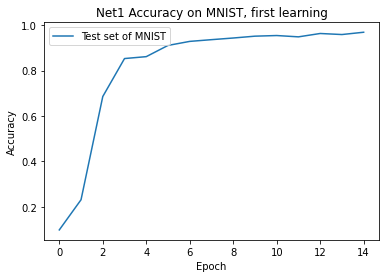

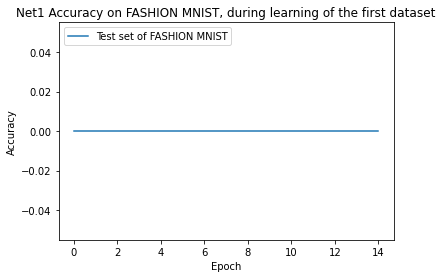

In [16]:
#define a special callback in order to test performance on each dataset at the end of each training epoch
fashion_callback = AdditionalValidationSets([(x_test_fashion, y_test_fashion, 'fashion')],batch_size=batch_size,verbose=0)
#train net1 on mnist dataset, bulk learning
net1.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(x_test,y_test), callbacks=fashion_callback, shuffle = True)
#extract MNIST accuracy to a list
val_accuracy_mnist = fashion_callback.history['val_accuracy']
val_accuracy_fashion = fashion_callback.history['fashion_accuracy']

#plot accuracy
plt.plot(val_accuracy_mnist)
plt.title('Net1 Accuracy on MNIST, first learning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test set of MNIST'], loc='upper left')
plt.show()

#plot accuracy on fashion dataset
plt.plot(val_accuracy_fashion)
plt.title('Net1 Accuracy on FASHION MNIST, during learning of the first dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test set of FASHION MNIST'], loc='upper left')
plt.show()

In [17]:
#create a variational autoencoder for the mnist dataset
#define a sampling class
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var))*K.exp(log_var/2)+mean

codings_dim = 20
leaky_relu = tf.keras.layers.LeakyReLU(0.2)
#define the encoder
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=2,activation=leaky_relu, padding='same')(inputs)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2,activation=leaky_relu, padding='same')(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=2,activation=leaky_relu, padding='same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(500,activation=leaky_relu)(x)
x = tf.keras.layers.Dense(200,activation=leaky_relu)(x)
x = tf.keras.layers.Dense(2*codings_dim)(x)
z_mean = tf.keras.layers.Dense(codings_dim)(x)
z_log_var = tf.keras.layers.Dense(codings_dim)(x)
z = Sampling()([z_mean, z_log_var])
variational_encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z])
#define the decoder
latent_inputs = tf.keras.Input(shape=(codings_dim,))
x = tf.keras.layers.Dense(500,activation=leaky_relu, input_shape=(codings_dim,))(latent_inputs)
x = tf.keras.layers.Dense(200,activation=leaky_relu)(x)
x = tf.keras.layers.Dense(28*28,activation='sigmoid')(x)
x = tf.keras.layers.Reshape((28,28,1))(x)
x = tf.keras.layers.Conv2DTranspose(filters=256,kernel_size=3, activation=leaky_relu, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, activation=leaky_relu, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=5, activation='sigmoid', padding='same')(x)
variational_decoder = tf.keras.Model(latent_inputs, x)
_,_,z = variational_encoder(inputs)
outputs = variational_decoder(z)
variational_autoencoder = tf.keras.Model(inputs, outputs)
#define the loss function
latent_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #KL divergence
variational_autoencoder.add_loss(K.mean(latent_loss)/784.) #scaling loss to the pixel scale and adding to the autoencoder

variational_autoencoder.compile(loss = 'binary_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))
#train the autoencodeur
epochs_now = 25
variational_autoencoder.fit(x_train, x_train, epochs=epochs_now, batch_size=128, validation_data=[x_test,x_test], shuffle = True)

Epoch 1/25
469/469 [==============================] - 22s 42ms/step - loss: 0.2263 - val_loss: 0.1793
Epoch 2/25
469/469 [==============================] - 19s 41ms/step - loss: 0.1703 - val_loss: 0.1584
Epoch 3/25
469/469 [==============================] - 19s 41ms/step - loss: 0.1552 - val_loss: 0.1503
Epoch 4/25
469/469 [==============================] - 19s 41ms/step - loss: 0.1478 - val_loss: 0.1415
Epoch 5/25
469/469 [==============================] - 19s 41ms/step - loss: 0.1436 - val_loss: 0.1522
Epoch 6/25
469/469 [==============================] - 19s 41ms/step - loss: 0.1409 - val_loss: 0.1368
Epoch 7/25
469/469 [==============================] - 19s 41ms/step - loss: 0.1389 - val_loss: 0.1365
Epoch 8/25
469/469 [==============================] - 19s 41ms/step - loss: 0.1372 - val_loss: 0.1353
Epoch 9/25
469/469 [==============================] - 19s 41ms/step - loss: 0.1358 - val_loss: 0.1370
Epoch 10/25
469/469 [==============================] - 19s 41ms/step - loss: 0.134

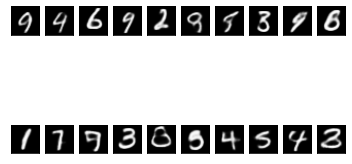

In [18]:
#use the autoencodeur to generate images with only some random noise as an input vector 
n_images = len(x_train)
z_sample = np.random.normal(size=(n_images, codings_dim))
images = variational_decoder.predict(z_sample)

#plot the decoded images for a visual inspection of their similarity to the MNIST dataset
for i in range(20):
    #decoded image
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Epoch 1/15
  5/235 [..............................] - ETA: 6s - loss: 2.9926 - accuracy: 0.1594

235/235 [==============================] - 8s 31ms/step - loss: 2.7520 - accuracy: 0.1400 - val_loss: 2.3911 - val_accuracy: 0.1262
Epoch 2/15
235/235 [==============================] - 7s 31ms/step - loss: 2.2533 - accuracy: 0.1473 - val_loss: 2.3131 - val_accuracy: 0.1009
Epoch 3/15
235/235 [==============================] - 7s 30ms/step - loss: 2.1012 - accuracy: 0.2358 - val_loss: 1.7484 - val_accuracy: 0.3556
Epoch 4/15
235/235 [==============================] - 7s 29ms/step - loss: 1.4436 - accuracy: 0.5168 - val_loss: 0.9220 - val_accuracy: 0.6888
Epoch 5/15
235/235 [==============================] - 7s 31ms/step - loss: 1.1040 - accuracy: 0.6459 - val_loss: 0.6000 - val_accuracy: 0.8200
Epoch 6/15
235/235 [==============================] - 7s 29ms/step - loss: 0.8847 - accuracy: 0.7324 - val_loss: 0.5362 - val_accuracy: 0.8169
Epoch 7/15
235/235 [==============================] - 7s 30ms/step - loss: 0.7334 - accuracy: 0.7976 - val_loss: 0.4252 - val_accuracy: 0.8603
Epoch 8/15

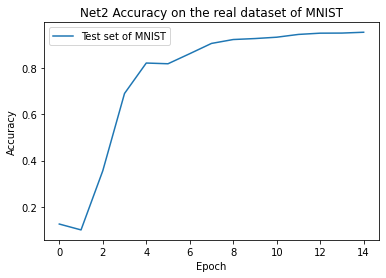

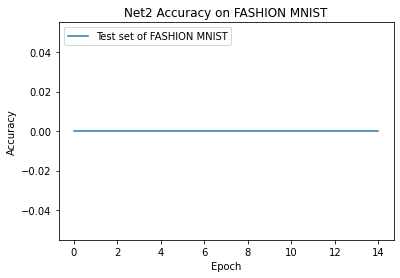

In [19]:
#create pseudotargets 
y_noise = net1.predict(images)
#compile and fit the neocortex
fashion_callback_net2 = AdditionalValidationSets([(x_test_fashion, y_test_fashion, 'fashion')],batch_size=batch_size,verbose=0)
net2.fit(images, y_noise, batch_size = batch_size, epochs = n_epochs,verbose=1, validation_data = (x_test,y_test), callbacks = fashion_callback_net2, shuffle = True) #using real data as a validation set

#extract accuracies on real datasets to see the generalization properties of the random noise
val_accuracy_mnist_net2 = fashion_callback_net2.history['val_accuracy']
val_accuracy_fashion_net2 = fashion_callback_net2.history['fashion_accuracy']

#plot accuracy
plt.plot(val_accuracy_mnist_net2)
plt.title('Net2 Accuracy on the real dataset of MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test set of MNIST'], loc='upper left')
plt.show()

#plot accuracy on fashion dataset
plt.plot(val_accuracy_fashion_net2)
plt.title('Net2 Accuracy on FASHION MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test set of FASHION MNIST'], loc='upper left')
plt.show()

In [20]:
#Create a new dataset containing raw examples and pseudosamples
len_pseudo_samples = int(len(x_train_fashion)*exp_replay_freq)
#generate some codings to be interleaved with the FASHION_MNIST dataset:
codings_to_interleave = tf.random.normal(shape=(len_pseudo_samples, codings_dim))
#generate some new images with these
images_to_interleave = variational_decoder.predict(codings_to_interleave)
#using net2, predict the class of each element in pseudoexamples
y_noise_2 = net2.predict(images_to_interleave, batch_size = batch_size)
#generate a new dataset
x_train_fashion_noise = tf.concat([x_train_fashion, images_to_interleave], axis=0)
y_train_fashion_noise = tf.concat([y_train_fashion, y_noise_2], axis=0)
#shuffle the dataset
x_train_fashion_noise, y_train_fashion_noise = shuffle(x_train_fashion_noise.numpy(), y_train_fashion_noise.numpy())

Epoch 1/15
  5/340 [..............................] - ETA: 8s - loss: 4.6238 - accuracy: 0.2109

340/340 [==============================] - 10s 29ms/step - loss: 0.9575 - accuracy: 0.7202 - val_loss: 0.1558 - val_accuracy: 0.9516
Epoch 2/15
340/340 [==============================] - 10s 29ms/step - loss: 0.6189 - accuracy: 0.8135 - val_loss: 0.1367 - val_accuracy: 0.9573
Epoch 3/15
340/340 [==============================] - 10s 29ms/step - loss: 0.5600 - accuracy: 0.8359 - val_loss: 0.1309 - val_accuracy: 0.9582
Epoch 4/15
340/340 [==============================] - 10s 30ms/step - loss: 0.5230 - accuracy: 0.8510 - val_loss: 0.1246 - val_accuracy: 0.9596
Epoch 5/15
340/340 [==============================] - 9s 28ms/step - loss: 0.5012 - accuracy: 0.8587 - val_loss: 0.1250 - val_accuracy: 0.9575
Epoch 6/15
340/340 [==============================] - 10s 29ms/step - loss: 0.4820 - accuracy: 0.8658 - val_loss: 0.1236 - val_accuracy: 0.9602
Epoch 7/15
340/340 [==============================] - 10s 29ms/step - loss: 0.4701 - accuracy: 0.8715 - val_loss: 0.1269 - val_accuracy: 0.9578
Epoc

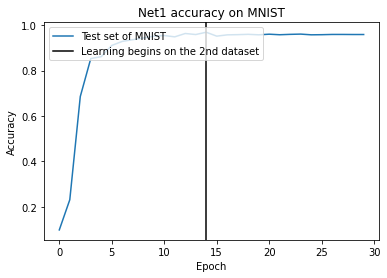

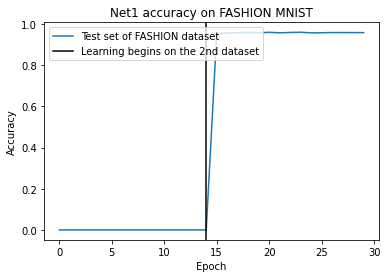

In [21]:
#define a special callback in order to test performance on each dataset at the end of each training epoch
callback_mnist = AdditionalValidationSets([(x_test, y_test, 'mnist')],batch_size=batch_size,verbose=0)
#train net1 on the new dataset
net1.fit(x_train_fashion_noise, y_train_fashion_noise, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(x_test, y_test), callbacks=callback_mnist, shuffle = True)


#plots the learning curve on MNIST before and after learning on pseudosamples interleaved with real samples
#extract accuracy to a list
val_accuracy_mnist.extend(callback_mnist.history['mnist_accuracy'])
plt.plot(val_accuracy_mnist)
plt.title('Net1 accuracy on MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axvline(x=int(n_epochs-1), color='k')
plt.legend(['Test set of MNIST', 'Learning begins on the 2nd dataset' ], loc='upper left')
plt.show()

#plot the learning curve on FASHION_MNIST (durinng the interleaving of the pseudosamples representing MNIST only)
val_accuracy_fashion.extend(callback_mnist.history['val_accuracy'])
plt.plot(val_accuracy_fashion)
plt.title('Net1 accuracy on FASHION MNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axvline(x=int(n_epochs-1), color='k')
plt.legend(['Test set of FASHION dataset', 'Learning begins on the 2nd dataset'], loc='upper left')
plt.show()

In [22]:
#evaluate net1 on mnist dataset
print("Loss and performance of net1 on the MNIST dataset:")
net1.evaluate(x_test, y_test, batch_size = batch_size)
#evaluate net1 on fashion_mnist dataset
print("Loss and performance of net1 on the FASHION_MNIST dataset:")
net1.evaluate(x_test_fashion, y_test_fashion, batch_size = batch_size)

Loss and performance of net1 on the MNIST dataset:
40/40 [==============================] - 0s 10ms/step - loss: 0.1243 - accuracy: 0.9588
Loss and performance of net1 on the FASHION_MNIST dataset:
40/40 [==============================] - 0s 10ms/step - loss: 0.4192 - accuracy: 0.8482


[0.41920411586761475, 0.8482000231742859]